In [1]:
import numpy as np
import pandas as pd
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

In [4]:
def f1_macro_score(y_true, y_pred):
    return f1_score(
        y_true=y_true,
        y_pred=y_pred,
        average='macro',
    )

### load pays.csv

In [5]:
pays = pd.read_csv('data/pays.csv')

In [6]:
pays.head()

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6


In [7]:
pays.tail()

,hash_inn_kt,hash_inn_dt,week,count,sum
5430145,260511,77935,5,2,399.6
5430146,260511,77935,12,2,439.6
5430147,260511,77935,14,2,7.6
5430148,260511,77935,15,2,79.6
5430149,260511,260511,10,2,7.6


### pays analysis

In [8]:
pays.shape

(5430150, 5)

In [9]:
pays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   hash_inn_kt  int64  
 1   hash_inn_dt  int64  
 2   week         int64  
 3   count        int64  
 4   sum          float64
dtypes: float64(1), int64(4)
memory usage: 207.1 MB


In [10]:
pays.describe().apply(lambda x: round(x, 2))

,hash_inn_kt,hash_inn_dt,week,count,sum
count,5430150.00,5430150.00,5430150.00,5430150.00,5429025.00
mean,128877.52,130520.33,11.62,2.92,393.94
std,75696.51,75646.41,6.33,5.05,7259.42
min,0.00,0.00,0.00,0.00,-0.40
25%,62929.00,64761.00,6.00,1.00,3.28
50%,127381.00,129588.00,12.00,2.00,14.57
75%,194385.00,196606.00,17.00,3.00,69.20
max,260511.00,260515.00,23.00,2530.00,3966399.60


In [11]:
# null values
pays.isna().sum(axis=0)

hash_inn_kt       0
hash_inn_dt       0
week              0
count             0
sum            1125
dtype: int64

### pays features analysis

In [12]:
for column in pays.columns:
    print(f"{column} nunique values: {pays[column].nunique()}")

hash_inn_kt nunique values: 152160
hash_inn_dt nunique values: 189772
week nunique values: 24
count nunique values: 344
sum nunique values: 309644


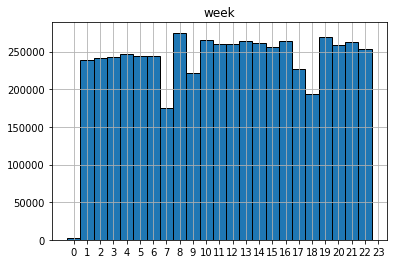

In [13]:
plt.hist(
    pays['week'], 
    edgecolor='black',
    bins=pays['week'].nunique()-1,
    align='left',
)
plt.title('week')
plt.xticks(np.arange(0, max(pays['week']) + 1, 1))
plt.grid()

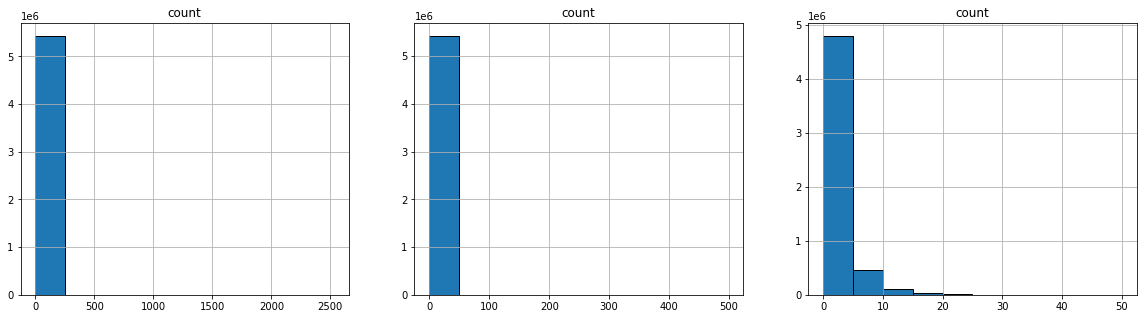

In [14]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.hist(pays['count'], edgecolor='black')
plt.title('count')
plt.grid()

plt.subplot(1, 3, 2)
plt.hist(pays[pays['count'] <= 500]['count'], edgecolor='black')
plt.title('count')
plt.grid()

plt.subplot(1, 3, 3)
plt.hist(pays[pays['count'] <= 50]['count'], edgecolor='black')
plt.title('count')
plt.grid()

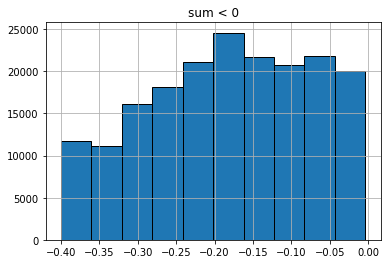

In [15]:
plt.hist(pays[pays['sum'] < 0]['sum'].dropna(), edgecolor='black')
plt.title('sum < 0')
plt.grid()

### load inn_info_public.csv

In [16]:
inn_info_public = pd.read_csv('data/inn_info_public.csv')

In [17]:
inn_info_public.head()

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True


In [18]:
inn_info_public.tail()

,hash_inn,okved2,region,is_public
240064,139170,4,12,True
240065,13553,12,12,True
240066,230402,12,12,True
240067,170104,63,12,True
240068,162752,-1,12,False


### inn_info_public analysis

In [19]:
inn_info_public.shape

(240069, 4)

In [20]:
inn_info_public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hash_inn   240069 non-null  int64
 1   okved2     240069 non-null  int64
 2   region     240069 non-null  int64
 3   is_public  240069 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 5.7 MB


In [21]:
inn_info_public.describe().apply(lambda x: round(x, 2))

,hash_inn,okved2,region
count,240069.00,240069.00,240069.00
mean,130236.42,18.77,58.94
std,75201.51,22.08,26.94
min,0.00,-1.00,0.00
25%,65170.00,-1.00,37.00
50%,130169.00,12.00,60.00
75%,195380.00,34.00,84.00
max,260515.00,79.00,90.00


In [22]:
# null values
inn_info_public.isnull().sum(axis=0)

hash_inn     0
okved2       0
region       0
is_public    0
dtype: int64

### inn_info_public features analysis

In [23]:
for column in inn_info_public.columns:
    print(f"{column} nunique values: {inn_info_public[column].nunique()}")

hash_inn nunique values: 240069
okved2 nunique values: 81
region nunique values: 91
is_public nunique values: 2


In [24]:
inn_info_public[inn_info_public['okved2'] != -1]['okved2'].value_counts()

12    44918
34    13654
14    10179
4      7617
52     6986
      ...  
2        90
36       84
13       68
73       64
1        50
Name: okved2, Length: 80, dtype: int64

In [25]:
# accuracy for the constant algorithm, which always produces the label of the largest class, is 27.8%
inn_info_public[inn_info_public['okved2'] != -1]['okved2'].value_counts(normalize=True)

12    0.278276
34    0.084589
14    0.063061
4     0.047189
52    0.043280
        ...   
2     0.000558
36    0.000520
13    0.000421
73    0.000396
1     0.000310
Name: okved2, Length: 80, dtype: float64

In [26]:
# train / test
inn_info_public['is_public'].value_counts()

True     161415
False     78654
Name: is_public, dtype: int64

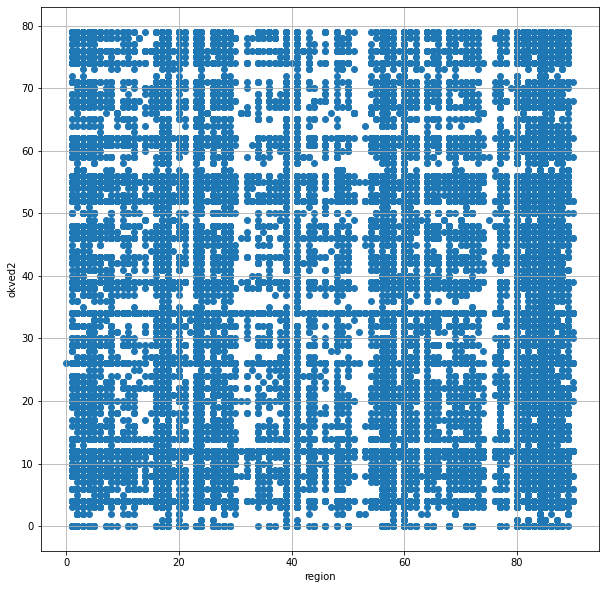

In [27]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.xlabel('region')
plt.ylabel('okved2')
plt.scatter(
    inn_info_public[inn_info_public['okved2'] != -1][['region']],
    inn_info_public[inn_info_public['okved2'] != -1][['okved2']],
)

In [28]:
# if a company is from region 0 or 40, then we can definitely tell its okved2
inn_info_public[inn_info_public['okved2'] != -1].pivot_table(
    index='region',
    values='okved2',
    aggfunc='nunique',
).sort_values(by='okved2')

,okved2
region,
0,1
40,1
75,2
79,3
52,5
...,...
82,77
85,78
84,79


### merge datasets

In [29]:
graph_df = pays.merge(
    right=inn_info_public.drop('is_public', axis=1),
    left_on='hash_inn_kt',
    right_on='hash_inn',
    how='left',
).drop(['hash_inn'], axis=1).merge(
    inn_info_public.drop('is_public', axis=1),
    left_on='hash_inn_dt',
    right_on='hash_inn',
    how='left',
    suffixes=['_kt', '_dt']
).drop(['hash_inn'], axis=1)

In [30]:
graph_df.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,okved2_kt,region_kt,okved2_dt,region_dt
0,0,0,1,4,38399.6,-1,84,-1.0,84.0
1,0,0,5,2,399.6,-1,84,-1.0,84.0
2,0,0,7,2,79.6,-1,84,-1.0,84.0
3,0,0,9,2,239.6,-1,84,-1.0,84.0
4,0,0,12,2,79.6,-1,84,-1.0,84.0


In [31]:
graph_df.tail()

,hash_inn_kt,hash_inn_dt,week,count,sum,okved2_kt,region_kt,okved2_dt,region_dt
5430145,260511,77935,5,2,399.6,12,84,14.0,84.0
5430146,260511,77935,12,2,439.6,12,84,14.0,84.0
5430147,260511,77935,14,2,7.6,12,84,14.0,84.0
5430148,260511,77935,15,2,79.6,12,84,14.0,84.0
5430149,260511,260511,10,2,7.6,12,84,12.0,84.0


### baseline

let's try for each INN give a industry of INN with which we send most payments

In [32]:
# straight-forward solution causes:
# "ValueError: Unstacked DataFrame is too big, causing int32 overflow"
# so we will iterate over chunks

chunks = np.linspace(pays['hash_inn_kt'].min(), pays['hash_inn_kt'].max() + 1)

inn_with_max_value = []

for i in trange(len(chunks) - 1):
    lower_inn = chunks[i]
    upper_inn = chunks[i+1]
    
    chunk = pays[(pays['hash_inn_kt'] >= lower_inn) & (pays['hash_inn_kt'] < upper_inn)]
    
    inn_with_max_value_chunk = chunk.pivot_table(
        index='hash_inn_kt',
        columns='hash_inn_dt',
        values='count',
        aggfunc='sum',
    ).idxmax(axis=1)  # take INN with max value (argmax)
    
    inn_with_max_value.append(inn_with_max_value_chunk)

100%|██████████| 49/49 [01:31<00:00,  1.86s/it]


In [33]:
inn_with_max_value = pd.concat(inn_with_max_value)
inn_with_max_value.name = 'inn_with_max_value'

In [34]:
inn_with_max_value

hash_inn_kt
0          70994
1          31310
2          56371
3          17473
4         173129
           ...  
260504     27254
260507    178054
260509      7833
260510    122389
260511     77935
Name: inn_with_max_value, Length: 152160, dtype: int64

In [35]:
y_true = inn_info_public.set_index(['hash_inn'])['okved2']

In [36]:
y_true.value_counts()

-1     78654
 12    44918
 34    13654
 14    10179
 4      7617
       ...  
 2        90
 36       84
 13       68
 73       64
 1        50
Name: okved2, Length: 81, dtype: int64

In [37]:
y_pred = pd.merge(
    left=inn_with_max_value,
    right=y_true,
    left_on='inn_with_max_value',
    right_index=True,
)['okved2']

In [38]:
y_pred.value_counts()

-1     49008
 12    25647
 34     7905
 52     5853
 4      5425
       ...  
 73       24
 13       23
 1        19
 49       15
 66        1
Name: okved2, Length: 81, dtype: int64

In [39]:
okved_compare = pd.merge(
    left=y_pred,
    right=y_true,
    left_index=True,
    right_index=True,
    how='inner',
    suffixes=['_pred', '_true'],
)

In [40]:
okved_compare

,okved2_pred,okved2_true
0,52,-1
249256,52,12
1,12,62
1319,12,8
4212,12,25
...,...,...
260465,-1,70
260469,12,55
260476,-1,-1
260484,70,-1


In [41]:
# filter -1 industry
filter_idx = (okved_compare['okved2_pred'] != -1) & (okved_compare['okved2_true'] != -1)

In [42]:
accuracy = accuracy_score(
    y_true=okved_compare[filter_idx]['okved2_true'],
    y_pred=okved_compare[filter_idx]['okved2_pred'],
)

In [43]:
# let's try for each INN give a industry of INN with which we send most payments
print(f"accuracy: {round(accuracy, 3)}")

accuracy: 0.262


In [44]:
print(
    classification_report(
        y_true=okved_compare[filter_idx]['okved2_true'],
        y_pred=okved_compare[filter_idx]['okved2_pred'],
    )
)

              precision    recall  f1-score   support

           0       0.21      0.20      0.21       396
           1       0.27      0.20      0.23        20
           2       0.13      0.56      0.21        27
           3       0.26      0.12      0.16       398
           4       0.40      0.42      0.41      3622
           5       0.21      0.16      0.18       122
           6       0.18      0.22      0.20       740
           7       0.09      0.08      0.09       371
           8       0.26      0.19      0.22      2146
           9       0.25      0.15      0.19       983
          10       0.09      0.17      0.12       391
          11       0.18      0.26      0.21       713
          12       0.44      0.36      0.40     20874
          13       0.05      0.08      0.06        13
          14       0.44      0.31      0.36      5001
          15       0.09      0.14      0.11       200
          16       0.17      0.08      0.11       989
          17       0.14    

### feature generation

In [45]:
# the number of unique INN to whom the transaction were made
feature_1 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='hash_inn_dt',
    aggfunc='nunique',
)['hash_inn_dt']
feature_1.head()

hash_inn_kt
0    34
1     1
2     3
3     1
4     6
Name: hash_inn_dt, dtype: int64

In [46]:
# the number of unique INN to whom the transaction were made
feature_1_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='hash_inn_dt',
    aggfunc='nunique').fillna(0)
feature_1_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,3.0,5.0,9.0,5.0,4.0,1.0,2.0,3.0,...,3.0,2.0,4.0,1.0,4.0,1.0,2.0,4.0,6.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0


In [47]:
# the number of weeks transactions were made throughout
feature_2 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='week',
    aggfunc='nunique',
)['week']
feature_2.head()

hash_inn_kt
0    22
1     7
2     2
3     1
4    10
Name: week, dtype: int64

In [48]:
# number of transactions
feature_3 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='count',
    aggfunc='nunique',
)['count']
feature_3.head()

hash_inn_kt
0    8
1    1
2    2
3    1
4    2
Name: count, dtype: int64

In [49]:
feature_3_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='count',
    aggfunc='nunique',
).fillna(0)
feature_3_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,2.0,3.0,2.0,3.0,4.0,1.0,2.0,2.0,...,2.0,2.0,2.0,1.0,3.0,1.0,2.0,3.0,3.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [50]:
feature_4 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='count',
    aggfunc='count',
)['count']
feature_4.head()

hash_inn_kt
0    85
1     7
2     3
3     1
4    17
Name: count, dtype: int64

In [51]:
feature_4_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='count',
    aggfunc='count',
).fillna(0)
feature_4_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,3.0,5.0,9.0,5.0,4.0,1.0,2.0,3.0,...,3.0,2.0,4.0,1.0,4.0,1.0,2.0,4.0,6.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0


In [52]:
feature_5 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='count',
    aggfunc='sum',
)['count']
feature_5.head()

hash_inn_kt
0    194
1     14
2      5
3      1
4     18
Name: count, dtype: int64

In [53]:
feature_5_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='count',
    aggfunc='sum',
).fillna(0)
feature_5_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,7.0,12.0,8.0,12.0,10.0,15.0,2.0,4.0,4.0,...,4.0,7.0,9.0,8.0,7.0,1.0,10.0,8.0,12.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0


In [54]:
# amount of payments
feature_6 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='sum',
    aggfunc='nunique',
)['sum']
feature_6.head()

hash_inn_kt
0    79
1     2
2     3
3     1
4    15
Name: sum, dtype: int64

In [55]:
feature_6_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='sum',
    aggfunc='nunique',
).fillna(0)
feature_6_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,3.0,5.0,9.0,5.0,4.0,1.0,2.0,3.0,...,3.0,2.0,4.0,1.0,4.0,1.0,2.0,4.0,6.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0


In [56]:
feature_7 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='sum',
    aggfunc='sum',
)['sum']
feature_7.head()

hash_inn_kt
0    253520.588
1       138.000
2        36.240
3        13.948
4        10.160
Name: sum, dtype: float64

In [57]:
feature_7_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='sum',
    aggfunc='sum',
).fillna(0)
feature_7_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,41035.224,31409.348,39972.628,2685.492,3634.288,44230.58,79.6,157.42,8609.956,...,3630.084,4605.192,2578.644,547.848,11581.4,1441.132,3549.84,7152.288,11547.904,0.0
1,0.0,0.000,0.000,0.000,0.000,12.400,12.40,0.0,12.40,25.200,...,0.000,25.200,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.0
2,0.0,30.500,0.000,0.000,0.000,0.000,0.00,0.0,0.00,0.000,...,0.000,0.000,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.0
3,0.0,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.00,0.000,...,0.000,13.948,0.000,0.000,0.0,0.000,0.00,0.000,0.000,0.0
4,0.0,0.000,0.000,0.000,0.000,0.000,1.04,0.0,1.54,0.000,...,0.000,1.060,2.180,0.000,0.0,0.560,0.00,0.000,1.180,0.0


In [58]:
# number of unique regions where transactions were made
feature_8 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='region_dt',
    aggfunc='nunique',
)['region_dt']
feature_8.head()

hash_inn_kt
0    15
1     1
2     3
3     1
4     1
Name: region_dt, dtype: int64

In [59]:
feature_8_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='region_dt',
    aggfunc='nunique',
).fillna(0)
feature_8_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,3.0,5.0,7.0,4.0,4.0,1.0,2.0,3.0,...,2.0,2.0,4.0,1.0,2.0,1.0,2.0,3.0,4.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [60]:
# number of unique industries of companies where transactions were made
feature_9 = graph_df.pivot_table(
    index='hash_inn_kt',
    values='okved2_dt',
    aggfunc='nunique',
)['okved2_dt']
feature_9.head()

hash_inn_kt
0    14
1     1
2     2
3     1
4     5
Name: okved2_dt, dtype: int64

In [61]:
feature_9_week = graph_df.pivot_table(
    index='hash_inn_kt',
    columns='week',
    values='okved2_dt',
    aggfunc='nunique',
).fillna(0)
feature_9_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_kt,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.0,2.0,4.0,6.0,2.0,3.0,1.0,2.0,3.0,...,3.0,2.0,2.0,1.0,4.0,1.0,1.0,4.0,4.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0


In [62]:
# the number of unique INN that made transactions to us
feature_10 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='hash_inn_kt',
    aggfunc='nunique',
)['hash_inn_kt']
feature_10.head()

hash_inn_dt
0     144
2       1
5       5
7       6
10      9
Name: hash_inn_kt, dtype: int64

In [63]:
feature_10_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='hash_inn_kt',
    aggfunc='nunique',
).fillna(0)
feature_10_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,12.0,9.0,22.0,17.0,18.0,21.0,19.0,27.0,15.0,...,28.0,22.0,15.0,2.0,12.0,30.0,22.0,30.0,22.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
10,0.0,5.0,1.0,6.0,0.0,1.0,4.0,0.0,4.0,0.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0


In [64]:
# the number of weeks during which transactions were made to us
feature_11 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='week',
    aggfunc='nunique',
)['week']
feature_11.head()

hash_inn_dt
0     22
2     10
5      8
7      9
10    14
Name: week, dtype: int64

In [65]:
# number of transactions
feature_12 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='count',
    aggfunc='nunique',
)['count']
feature_12.head()

hash_inn_dt
0     15
2      6
5      1
7      2
10     5
Name: count, dtype: int64

In [66]:
feature_12_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='count',
    aggfunc='nunique',
).fillna(0)
feature_12_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,3.0,3.0,5.0,3.0,6.0,5.0,4.0,6.0,5.0,...,5.0,5.0,3.0,2.0,3.0,6.0,6.0,6.0,6.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10,0.0,2.0,1.0,3.0,0.0,1.0,3.0,0.0,4.0,0.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0


In [67]:
feature_13 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='count',
    aggfunc='count',
)['count']
feature_13.head()

hash_inn_dt
0     447
2      10
5      19
7      13
10     30
Name: count, dtype: int64

In [68]:
feature_13_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='count',
    aggfunc='count',
).fillna(0)
feature_13_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,12.0,9.0,22.0,17.0,18.0,21.0,19.0,27.0,15.0,...,28.0,22.0,15.0,2.0,12.0,30.0,22.0,30.0,22.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
10,0.0,5.0,1.0,6.0,0.0,1.0,4.0,0.0,4.0,0.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0


In [69]:
feature_14 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='count',
    aggfunc='sum',
)['count']
feature_14.head()

hash_inn_dt
0     1077
2       29
5       38
7       17
10      72
Name: count, dtype: int64

In [70]:
feature_14_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='count',
    aggfunc='sum',
).fillna(0)
feature_14_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,23.0,33.0,43.0,27.0,50.0,53.0,35.0,57.0,35.0,...,60.0,44.0,52.0,28.0,25.0,80.0,66.0,73.0,69.0,0.0
2,0.0,0.0,4.0,1.0,0.0,0.0,5.0,0.0,0.0,6.0,...,0.0,2.0,0.0,2.0,0.0,3.0,0.0,0.0,3.0,0.0
5,0.0,8.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,8.0,...,4.0,2.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0
7,0.0,2.0,2.0,3.0,0.0,3.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
10,0.0,7.0,2.0,13.0,0.0,2.0,8.0,0.0,13.0,0.0,...,2.0,2.0,3.0,6.0,4.0,6.0,2.0,0.0,2.0,0.0


In [71]:
# amount of payments
feature_15 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='sum',
    aggfunc='nunique',
)['sum']
feature_15.head()

hash_inn_dt
0     383
2       9
5       9
7      12
10     21
Name: sum, dtype: int64

In [72]:
feature_15_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='sum',
    aggfunc='nunique',
).fillna(0)
feature_15_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,12.0,9.0,22.0,17.0,18.0,21.0,19.0,27.0,15.0,...,27.0,22.0,15.0,2.0,12.0,30.0,22.0,29.0,22.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,2.0,0.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
10,0.0,5.0,1.0,4.0,0.0,1.0,3.0,0.0,4.0,0.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0


In [73]:
feature_16 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='sum',
    aggfunc='sum',
)['sum']
feature_16.head()

hash_inn_dt
0     172026.108
2        427.484
5        122.668
7       7809.116
10       152.616
Name: sum, dtype: float64

In [74]:
feature_16_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='sum',
    aggfunc='sum',
).fillna(0)
feature_16_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,38628.548,5739.064,2545.468,895.28,6026.776,5689.512,1484.632,1848.276,6266.144,...,2752.644,2196.148,13977.86,130.252,965.368,2810.040,5353.768,6273.068,3214.008,0.0
2,0.0,0.000,15.728,4.436,0.00,0.000,23.792,0.000,0.000,110.480,...,0.000,30.704,0.00,30.704,0.000,62.872,0.000,0.000,48.876,0.0
5,0.0,31.948,0.000,0.000,0.00,34.020,0.000,0.000,0.000,1.220,...,0.340,15.600,0.00,0.000,0.340,15.600,0.000,0.000,0.000,0.0
7,0.0,948.956,872.624,687.632,0.00,1837.636,1012.420,2301.072,23.600,0.000,...,0.000,0.000,0.00,0.000,0.000,16.880,0.000,108.296,0.000,0.0
10,0.0,20.188,2.000,12.956,0.00,1.600,11.760,0.000,14.000,0.000,...,12.400,3.600,2.00,4.400,4.640,7.040,3.200,0.000,52.832,0.0


In [75]:
# the number of unique regions from which transactions were made to us
feature_17 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='region_kt',
    aggfunc='nunique',
)['region_kt']
feature_17.head()

hash_inn_dt
0     21
2      1
5      1
7      2
10     3
Name: region_kt, dtype: int64

In [76]:
feature_17_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='region_kt',
    aggfunc='nunique',
).fillna(0)
feature_17_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,6.0,2.0,9.0,7.0,4.0,7.0,7.0,8.0,3.0,...,8.0,6.0,5.0,2.0,5.0,10.0,7.0,8.0,7.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
10,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [77]:
# the number of unique industries of companies from which transactions were made to us
feature_18 = graph_df.pivot_table(
    index='hash_inn_dt',
    values='okved2_kt',
    aggfunc='nunique',
)['okved2_kt']
feature_18.head()

hash_inn_dt
0     34
2      1
5      3
7      4
10     4
Name: okved2_kt, dtype: int64

In [78]:
feature_18_week = graph_df.pivot_table(
    index='hash_inn_dt',
    columns='week',
    values='okved2_kt',
    aggfunc='nunique',
).fillna(0)
feature_18_week.head()

week,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
hash_inn_dt,,,,,,,,,,,,,,,,,,,,,
0,0.0,7.0,6.0,14.0,8.0,10.0,8.0,10.0,11.0,7.0,...,16.0,13.0,7.0,2.0,8.0,14.0,10.0,14.0,14.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
10,0.0,4.0,1.0,3.0,0.0,1.0,2.0,0.0,3.0,0.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0


### combine generated features

In [79]:
df = inn_info_public.set_index(['hash_inn']).copy()

for i, feature in enumerate([
    feature_1,
    feature_2,
    feature_3,
    feature_4,
    feature_5,
    feature_6,
    feature_7,
    feature_8,
    feature_9,
    feature_10,
    feature_11,
    feature_12,
    feature_13,
    feature_14,
    feature_15,
    feature_16,
    feature_17,
    feature_18,
]):
    feature.name = i
    df = df.merge(feature, how='left', left_index=True, right_index=True)
    df.fillna(0, inplace=True)

In [80]:
df.head()

,okved2,region,is_public,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,17
hash_inn,,,,,,,,,,,,,,,,,,,,,
61058,34,86,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,1.0,4.0,12.0,4.0,89.456,1.0,1.0
8311,18,86,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,6.0,3.0,6.0,11.0,6.0,39.960,1.0,1.0
130273,-1,86,False,1.0,2.0,1.0,2.0,4.0,1.0,611.2,...,1.0,6.0,14.0,6.0,26.0,71.0,23.0,9188.600,3.0,4.0
64081,43,86,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,8.0,1.0,11.0,22.0,10.0,211.868,2.0,3.0
218005,12,86,True,1.0,4.0,3.0,4.0,20.0,4.0,779.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0


In [81]:
# df_week = inn_info_public.set_index(['hash_inn']).copy()

# for feature in [
#     feature_1_week,
#     feature_2,
#     feature_3_week,
#     feature_4_week,
#     feature_5_week,
#     feature_6_week,
#     feature_7_week,
#     feature_8_week,
#     feature_9_week,
#     feature_10_week,
#     feature_11,
#     feature_12_week,
#     feature_13_week,
#     feature_14_week,
#     feature_15_week,
#     feature_16_week,
#     feature_17_week,
#     feature_18_week,
# ]:
#     df_week = df_week.merge(feature, how='left', left_index=True, right_index=True)

In [82]:
# df_week.head()

In [83]:
# linear independent
(df.corr() == 1).sum(axis=1)

okved2       1
region       1
is_public    1
0            1
1            1
2            1
3            1
4            1
5            1
6            1
7            1
8            1
9            1
10           1
11           1
12           1
13           1
14           1
15           1
16           1
17           1
dtype: int64

<AxesSubplot:>

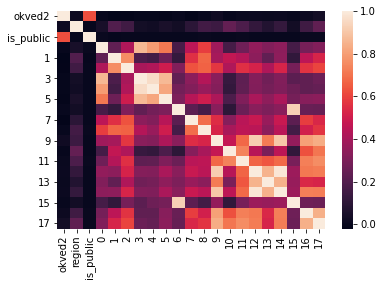

In [84]:
# corr
sns.heatmap(df.corr())

### train/val

In [85]:
X = df[df['is_public'] == True].drop(['okved2', 'is_public'], axis=1)
y = df[df['is_public'] == True]['okved2']

X_test = df[df['is_public'] == False].drop(['okved2', 'is_public'], axis=1)

In [86]:
X.shape

(161415, 19)

In [87]:
# undersampling 50%
_, X, _, y = train_test_split(
    X, y,
    test_size=0.5,
    shuffle=True,
    stratify=y,
    random_state=42,
)

In [88]:
X.shape

(80708, 19)

In [89]:
# train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=True,
    stratify=y,
    random_state=42,
)

### OHE

In [90]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [91]:
X_region_ohe = pd.DataFrame(
    data=ohe.fit_transform(X[['region']]).toarray(),
    columns=ohe.get_feature_names(),
    index=X.index,
)
X_test_region_ohe = pd.DataFrame(
    data=ohe.transform(X_test[['region']]).toarray(),
    columns=ohe.get_feature_names(),
    index=X_test.index,
)

In [92]:
X_region_ohe.head()

,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,...,x0_81,x0_82,x0_83,x0_84,x0_85,x0_86,x0_87,x0_88,x0_89,x0_90
hash_inn,,,,,,,,,,,,,,,,,,,,,
212461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
135428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
258693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
X_region_ohe.shape

(80708, 88)

In [94]:
X_ohe = pd.concat(
    [X.drop(['region'], axis=1), X_region_ohe],
    axis=1,
)
X_test_ohe = pd.concat(
    [X_test.drop(['region'], axis=1), X_test_region_ohe],
    axis=1,
)

In [95]:
X_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,x0_81,x0_82,x0_83,x0_84,x0_85,x0_86,x0_87,x0_88,x0_89,x0_90
hash_inn,,,,,,,,,,,,,,,,,,,,,
212461,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45207,515.0,22.0,18.0,2265.0,6601.0,1960.0,141896.996,20.0,37.0,111.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16955,2.0,7.0,1.0,10.0,10.0,2.0,115.640,1.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
135428,21.0,17.0,2.0,36.0,39.0,35.0,1309.052,1.0,10.0,10.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
258693,1.0,11.0,2.0,11.0,72.0,11.0,1073.592,1.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
X.shape, X_ohe.shape

((80708, 19), (80708, 106))

### train/val

In [97]:
# train_test_split
X_train_ohe, X_val_ohe, y_train_ohe, y_val_ohe = train_test_split(
    X_ohe, y,
    test_size=0.3,
    shuffle=True,
    stratify=y,
    random_state=42,
)

### KNN

In [98]:
knn = KNeighborsClassifier()
scaler = StandardScaler()

In [99]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [100]:
param_grid = {
    'n_neighbors': [5, 10, 15],
    'p': [1, 2],
}
scoring = make_scorer(f1_macro_score)
cv = StratifiedKFold(n_splits=3)

In [101]:
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=2,
)

In [102]:
%%time

grid.fit(scaler.fit_transform(X_train_ohe), y_train_ohe)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................................n_neighbors=5, p=1; total time= 1.5min
[CV] END .................................n_neighbors=5, p=1; total time= 1.4min
[CV] END .................................n_neighbors=5, p=1; total time= 1.4min
[CV] END .................................n_neighbors=5, p=2; total time=  15.3s
[CV] END .................................n_neighbors=5, p=2; total time=  15.9s
[CV] END .................................n_neighbors=5, p=2; total time=  15.8s
[CV] END ................................n_neighbors=10, p=1; total time= 1.4min
[CV] END ................................n_neighbors=10, p=1; total time= 1.4min
[CV] END ................................n_neighbors=10, p=1; total time= 1.4min
[CV] END ................................n_neighbors=10, p=2; total time=  15.4s
[CV] END ................................n_neighbors=10, p=2; total time=  15.9s
[CV] END ................................n_neighb

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15], 'p': [1, 2]},
             scoring=make_scorer(f1_macro_score), verbose=2)

In [103]:
print(f"best f1-macro: {round(grid.best_score_, 3)}")
print(f"best params: {grid.best_params_}")

best f1-macro: 0.026
best params: {'n_neighbors': 5, 'p': 2}


In [104]:
y_pred = grid.predict(scaler.transform(X_val_ohe))

In [105]:
val_accuracy = accuracy_score(y_pred, y_val_ohe)
print(f"validation accuracy: {round(val_accuracy, 3)}")

validation accuracy: 0.227


In [106]:
print(
    classification_report(
        y_true=y_val_ohe,
        y_pred=y_pred,
    )
)

              precision    recall  f1-score   support

           0       0.01      0.02      0.01       122
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        13
           3       0.01      0.04      0.02       126
           4       0.07      0.14      0.09      1143
           5       0.00      0.00      0.00        38
           6       0.06      0.12      0.08       368
           7       0.00      0.00      0.00        97
           8       0.04      0.07      0.06       699
           9       0.03      0.04      0.03       283
          10       0.02      0.03      0.02       151
          11       0.06      0.11      0.08       428
          12       0.35      0.60      0.44      6738
          13       0.00      0.00      0.00        10
          14       0.22      0.26      0.23      1527
          15       0.00      0.00      0.00        65
          16       0.02      0.01      0.01       281
          17       0.00    

### LogReg

In [107]:
# poly = PolynomialFeatures(degree=1)
# scaler = StandardScaler()
# logreg = LogisticRegression()

# model_pipe = Pipeline([
#     ('poly', poly),
#     ('scaler', scaler),
#     ('logreg', logreg),
# ])

In [108]:
# logreg.get_params()

In [109]:
# param_grid = {
#     'logreg__penalty': ['l2'],
#     'logreg__multi_class': ['ovr', 'multinomial'],
#     'logreg__C': np.linspace(1, 10, 10),
# }
# scoring = make_scorer(f1_macro_score)
# cv = StratifiedKFold(n_splits=3)

In [110]:
# grid = RandomizedSearchCV(
#     estimator=logreg,
#     param_distributions=param_grid,
#     n_iter=10,
#     scoring=scoring,
#     cv=cv,
#     verbose=2,
# )

In [111]:
# %%time
# grid.fit(X_train_ohe, y_train_ohe)

In [112]:
# print(f"best f1-macro: {round(grid.best_score_, 3)}")
# print(f"best params: {grid.best_params_}")

In [113]:
# y_pred = grid.predict(X_val_ohe)

In [114]:
# val_accuracy = accuracy_score(y_pred, y_val_ohe)
# print(f"validation accuracy: {round(val_accuracy, 3)}")

In [115]:
# print(
#     classification_report(
#         y_true=y_val_ohe,
#         y_pred=y_pred,
#     )
# )

### RF

In [116]:
rf = RandomForestClassifier()

In [117]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [118]:
param_grid = {
    'max_depth': [None, 3, 5, 7, 9],
    'n_estimators': [50, 100, 500],
}
scoring = make_scorer(f1_macro_score)
cv = StratifiedKFold(n_splits=3)

In [119]:
grid = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring=scoring,
    cv=cv,
    verbose=2,
)

In [120]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=   2.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   2.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   1.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   6.5s
[CV] END ....................max_depth=None, n_estimators=50; total time=   6.5s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.5s
[CV] END ......................max_depth=9, n_estimators=500; total time=  22.4s
[CV] END ......................max_depth=9, n_estimators=500; total time=  22.2s
[CV] END ......................max_depth=9, n_es

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 3, 5, 7, 9],
                                        'n_estimators': [50, 100, 500]},
                   scoring=make_scorer(f1_macro_score), verbose=2)

In [121]:
print(f"best f1-macro: {round(grid.best_score_, 3)}")
print(f"best params: {grid.best_params_}")

best f1-macro: 0.028
best params: {'n_estimators': 50, 'max_depth': None}


In [122]:
y_pred = grid.predict(X_val)

In [123]:
val_accuracy = accuracy_score(y_pred, y_val)
print(f"validation accuracy: {round(val_accuracy, 3)}")

validation accuracy: 0.265


In [124]:
print(
    classification_report(
        y_true=y_val,
        y_pred=y_pred,
    )
)

              precision    recall  f1-score   support

           0       0.02      0.01      0.01       122
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        13
           3       0.03      0.02      0.02       126
           4       0.06      0.03      0.04      1143
           5       0.00      0.00      0.00        38
           6       0.08      0.04      0.05       368
           7       0.00      0.00      0.00        97
           8       0.07      0.04      0.05       699
           9       0.05      0.03      0.04       283
          10       0.02      0.01      0.01       151
          11       0.09      0.06      0.08       428
          12       0.34      0.70      0.46      6738
          13       0.00      0.00      0.00        10
          14       0.26      0.35      0.30      1527
          15       0.00      0.00      0.00        65
          16       0.06      0.03      0.04       281
          17       0.00    

### XGB

In [125]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='merror')

In [126]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eval_metric': 'merror'}

In [127]:
param_grid = {
    'max_depth': [2, 3, 5],
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.1, 0.01, 0.001]
}
scoring = make_scorer(f1_macro_score)
cv = StratifiedKFold(n_splits=3)

In [128]:
grid = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring=scoring,
    cv=cv,
    verbose=2,
)

In [129]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 2.8min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 2.9min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 2.9min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 1.4min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 1.4min
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time= 1.5min
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=  35.3s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=  35.8s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=  35.3s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=  52.9s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time= 1.0min
[CV] END ....learning_rate=0.1, max_depth=3, n_e

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='merror', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=Non...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_la

In [130]:
print(f"best f1-macro: {round(grid.best_score_, 3)}")
print(f"best params: {grid.best_params_}")

best f1-macro: 0.018
best params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}


In [131]:
y_pred = grid.predict(X_val)

In [132]:
val_accuracy = accuracy_score(y_pred, y_val)
print(f"validation accuracy: {round(val_accuracy, 3)}")

validation accuracy: 0.311


In [133]:
print(
    classification_report(
        y_true=y_val,
        y_pred=y_pred,
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00       126
           4       1.00      0.00      0.00      1143
           5       0.00      0.00      0.00        38
           6       0.24      0.01      0.03       368
           7       0.00      0.00      0.00        97
           8       1.00      0.00      0.00       699
           9       0.00      0.00      0.00       283
          10       0.00      0.00      0.00       151
          11       0.16      0.02      0.04       428
          12       0.31      0.95      0.46      6738
          13       0.00      0.00      0.00        10
          14       0.30      0.24      0.27      1527
          15       0.00      0.00      0.00        65
          16       0.00      0.00      0.00       281
          17       0.00    